# Variational Autoencoder in TensorFlow

The main motivation for this post was that I wanted to get more experience with both [Variational Autoencoders](http://arxiv.org/abs/1312.6114) (VAEs) and with [Tensorflow](http://www.tensorflow.org/). Thus, implementing the former in the latter sounded like a good idea for learning about both at the same time. This post summarizes the result.

Note: The post was updated on December 7th 2015:
  * a bug in the computation of the latent_loss was fixed (removed an erroneous factor 2). Thanks Colin Fang for pointing this out.
  * Using a Bernoulli distribution rather than a Gaussian distribution in the generator network

Note: The post was updated on January 3rd 2017:
  * changes required for supporting TensorFlow v0.12 and Python 3 support

Let us first do the necessary imports, load the data (MNIST), and define some helper functions.

In [1]:
import numpy as np
import tensorflow as tf
import levy as lvy
#from scipy.special import gamma

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)


In [2]:
# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/mnist/input_data.py
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples
print(n_samples)


Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
55000


In [3]:
# http://www.cs.utoronto.ca/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar = unpickle('CIFAR\data_batch_1')
#cifar
#print(cifar.keys())
dat = cifar[b'data'] # 10k by 3072 (= 1024*3)
cifardat = np.zeros((10000,1024), dtype=np.float32)


for x in range(0, 10000):
    if ((x % 500) == 0):
        print(x)
    for y in range(0,1024):
        cifardat[x,y] = .2989*dat[x,y] + .5870*dat[x,y+1024] + .1140*dat[x,y+2048]
        cifardat[x,y] = cifardat[x,y]/256
        #0.2989, 0.5870, 0.1140
        # from https://stackoverflow.com/questions/687261/converting-rgb-to-grayscale-intensity#689547
cifardat = np.clip(cifardat,0.0,1.0)        
n_samples = 10000

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [4]:
# make reduced version? 20x20
mask = 12
masker = np.zeros(mask*mask,dtype = np.int)
maskstart = ((32-mask)/2)*32;
for x in range(0,mask):
    masker[(x)*mask : (x)*mask + mask] = np.arange(maskstart + (32-mask)/2,maskstart + (32-mask)/2 + mask)
    maskstart = maskstart + 32

cifardatsm = np.zeros((10000,(mask*mask)),dtype=np.float32)
for i in range(0,10000):
    cifardatsm[i,:] = cifardat[i,masker]
print(cifardatsm.shape)

(10000, 144)


[330 331 332 333 334 335 336 337 338 339 340 341 362 363 364 365 366 367
 368 369 370 371 372 373 394 395 396 397 398 399 400 401 402 403 404 405
 426 427 428 429 430 431 432 433 434 435 436 437 458 459 460 461 462 463
 464 465 466 467 468 469 490 491 492 493 494 495 496 497 498 499 500 501
 522 523 524 525 526 527 528 529 530 531 532 533 554 555 556 557 558 559
 560 561 562 563 564 565 586 587 588 589 590 591 592 593 594 595 596 597
 618 619 620 621 622 623 624 625 626 627 628 629 650 651 652 653 654 655
 656 657 658 659 660 661 682 683 684 685 686 687 688 689 690 691 692 693]


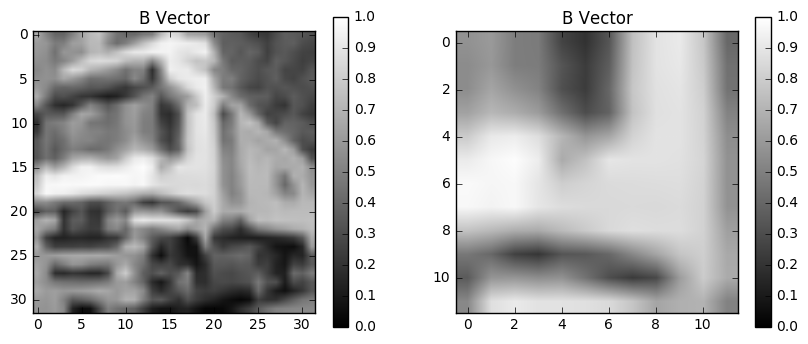

In [5]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cifardat[1,:].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
plt.title("B Vector")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(cifardatsm[1,:].reshape(mask, mask), vmin=0, vmax=1, cmap="gray")
plt.title("B Vector")
plt.colorbar()
print(masker)

In [6]:
alpha = 2.0 # fixed - 2.0 is normal, 1.0 is cauchy. 
# these appear to be only workable values...
# otherwise, can only approximate pdf (likelihood) in such a way that tf cannot optimize over
beta = 0.0
# Synthetic Data, try with less basis rns
synB = np.random.rand(25,5) - .5 # 10 rows (basis) of 25 random nums from -.5 to .5
synztrain = lvy.random(alpha, beta, mu=0.0, sigma=1.0, shape=[5,10000], par=0)
synztest = lvy.random(alpha, beta, mu=0.0, sigma=1.0, shape=[5,2000], par=0)
synxtrain = np.dot(synB,synztrain)
#synxtrain = synxtrain + np.random.normal(0.0,.25,synxtrain.shape)
synxtrain = np.clip(synxtrain, 0.0+.001, 1.0-.001)
synxtest = np.dot(synB,synztest)
synxtest2 = synxtest + np.random.normal(0.0,.25,synxtest.shape) # noised version is seperate here
synxtest = np.clip(synxtest,0.0,1.0)
synxtest2 = np.clip(synxtest2,0.0,1.0)
synxtrain.shape
n_samples = synxtrain.shape[1]
print(n_samples)
print(synxtrain.shape)


10000
(25, 10000)


In [7]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

n_samples = 10000 # 10ksynth or cifar, 55k for mnist

Based on this, we define now a class "VariationalAutoencoder" with a [sklearn](http://scikit-learn.org)-like interface that can be trained incrementally with mini-batches using partial_fit. The trained model can be used to reconstruct unseen input, to generate new samples, and to map inputs to the latent space.

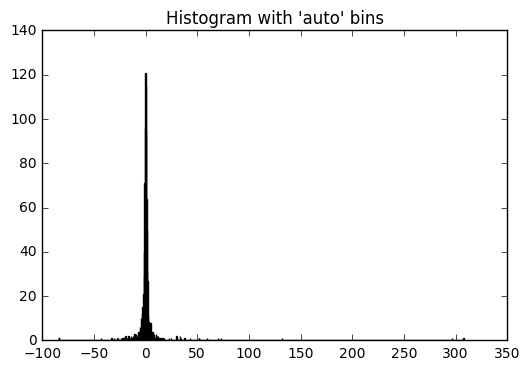

-83.4725397281
4.5683867938350886e-05
307.843475475
3.3588469250389608e-06
Tensor("Greater:0", shape=(10,), dtype=bool)
[ 1.  1. -1. -1.  1. -1. -1. -1.  1. -1.]
[False False  True  True False  True  True False  True  True]
[ True  True False False  True False False False  True False]
[-1. -1. -1. -1.  1. -1.]
[ 1.  1.  1.  1.]


In [63]:
#eps = tf.contrib.distributions.Laplace(loc = 0.0,scale = 1.0)
#test = eps.sample([100,10])
#test = eps.sample([2,2])
#test = tf.reshape(test,[100,10])
#test
#eps2 = tf.random_normal((100, 10), 0, 1, 
#                               dtype=tf.float32)
#eps2
## Analyticial KL between two laplace (1D) is given by
## http://www.wolframalpha.com/input/?i=integral+((1%2F(2*b))*exp(-abs(x-u)%2Fb)+*+log((1%2F(2*b))*exp(-abs(x-u)%2Fb)%2F((1%2F(2))*exp(-abs(x))))++++)
## kD Laplace paper
## http://eo.uit.no/publications/te-spl-06.pdf
## MV Lap
## https://en.wikipedia.org/wiki/Multivariate_Laplace_distribution#cite_ref-multi_3-1
## KL via MCMC
## https://stats.stackexchange.com/questions/280885/estimate-the-kullback-leibler-kl-divergence-with-monte-carlo?rq=1

## playground
#with tf.Session() as sess:
#    print(sess.run([test])) # print matrix
#u = tf.convert_to_tensor([0.0, 1, 2, 3, 4],dtype=np.float32)
#sigma = tf.convert_to_tensor([1.0, 1, 1, 1, 2],dtype=np.float32)
#x = tf.convert_to_tensor([1.0, 1, 1, 1, 1],dtype=np.float32)
#u = u + .5 basic addition
#u = u*1.5  basic multiplication
#Mbase =tf.ones([5, 5], tf.float32) - tf.eye(5)
#k = tf.reduce_prod(tf.reciprocal(2*sigma))
#eterm = tf.exp(-(tf.abs(x - u))/sigma)
#s = 5*tf.log(.5)
#Cbase = -sigma * eterm
#Cbasef = tf.reshape(tf.tile(Cbase,[5]),[5,tf.shape(Cbase)[0]])
#with tf.Session() as sess:
    #print(sess.run([Mbase])) # print matrix
    #print(sess.run([k])) 
    #print(sess.run([eterm]))
    #print(sess.run([s]))
    #print(sess.run([Cbase]))
    #print(sess.run([Cbasef]))
    
## Fancy analytic KL fails
## By estimation:
## Draw N points from Q, KLest = (1/N) sum(log(Q(x)/P(x)))
# Levy Stuff
#alpha = 2 # stability hyperparam from .5 to 2; 2 is normal, 1 is cauchy, .5 is minimum
#beta = 0  # skewness hyperparam - should always be 0?
# not for normal, sigma^2 = 2*c^2, , aka our scale param is larger by factor of sqrt(2)
#print(lvy.random(alpha, beta, mu=0.0, sigma=1.0, shape=2, par=0)) # alpha beta mu sigma size
pts = lvy.random(alpha, beta, mu=0.0, sigma=1.0, shape=1000, par=0)
plt.hist(pts, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()
xmin = tf.reduce_min(pts)
print(xmin.eval())
print(lvy.levy(xmin.eval(),alpha,beta,0,1.0))
xmax = tf.reduce_max(pts)
print(xmax.eval())
print(lvy.levy(xmax.eval(),alpha,beta,0,1.0))
# may only work well for generating large amounts of #s at once
# however, we will generate dimension*batch at once, which should be sufficient
x = tf.sign(tf.random_uniform((10,), -1, 1))
tester = x > 0
print(tester)
#x[tester]
nptest = tester.eval()
nptest
#x[nptest]
npx = x.eval()
nptest2 = npx>0
print(npx)
print(nptest)
print(nptest2)
print(npx[nptest])
print(npx[nptest2])
x2 = tf.convert_to_tensor(npx[nptest])


In [8]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self.sess = tf.InteractiveSession()
        self._create_loss_optimizer()

        # Launch the session
        self.sess.run(tf.global_variables_initializer())
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        #Stable
        eps = lvy.random(alpha,beta,0.0,1.0,[self.batch_size,n_z])
        #Laplacian
        #eps = tf.contrib.distributions.Laplace(loc = 0.0,scale = 1.0).sample([self.batch_size,n_z])
        #with tf.Session() as sess:
        #    print(sess.run([tf.shape(eps)]))
        #with tf.Session() as sess:
            #print(sess.run([tf.shape(self.z_log_sigma_sq)]))
        #eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
        #                       dtype=tf.float32)
        # z = mu + sigma*epsilon
        #self.z = tf.add(self.z_mean, 
        #                tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))
        self.z = tf.add(self.z_mean,tf.multiply(tf.exp(self.z_log_sigma_sq),eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-6 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-6 + 1 - self.x_reconstr_mean),
                           1)
        reconstr_loss_2 = tf.reduce_sum(tf.pow(self.x - self.x_reconstr_mean, 2))
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        # Now new KL term
        #k = tf.reduce_prod(tf.reciprocal(2*self.z_log_sigma_sq))
        #eterm = tf.exp(-(tf.abs(x - self.z_mean))/self.z_log_sigma_sq)
        #A = tf.reduce_sum(tf.log(tf.reciprocal(2*self.z_log_sigma_sq)))
        #
        # Most recent - Cauchy (if norm, uncomment original)
        # from drawn single point z (per trial, many trials per batch)
        # estimate KL = exp_P P/Q
        # = sum_i(log(p_i)-log(q_i))
        
        sigma = tf.exp(self.z_log_sigma_sq)
        logp = tf.log((1.0/(np.pi*sigma))*((sigma*sigma)/((self.z-self.z_mean)*(self.z-self.z_mean)+(sigma*sigma))))
        logq = tf.log((1.0/np.pi)*(1.0/((self.z*self.z)+1.0)))        
        latent_loss = tf.reduce_sum(logp-logq)
        
        
        l1 = sum(tf.reduce_sum(tf.abs(var)) for var in tf.trainable_variables() if not 'biases' in var.name)
        lam = .05 # .5 for synth, 1 mnist, .05 for cifarsm. Possibly helpful because of very small size of synth, large ndim for cifarsm?
        lam2 = .00
        self.cost = tf.reduce_sum(reconstr_loss_2 + lam*latent_loss + lam2*l1)   # average over batch
        #self.cost = tf.reduce_sum(reconstr_loss_2)
        #self.cost = tf.reduce_sum(latent_loss)
        
        
        
        #X = np.random.randn(1,self.network_architecture["n_input"]) # randnorm
        X = np.random.rand(100,self.network_architecture["n_input"])   # uniform 0-1, force it to have batch size
        #X = lvy.random(alpha,beta,0,1.0,self.network_architecture["n_input"])
        #X = tf.add(self.z_mean,tf.multiply(tf.exp(self.z_log_sigma_sq),X))
        print(self.x)
        print(self.x_reconstr_mean)
        self.sess.run(tf.global_variables_initializer())
        print(self.sess.run([self.x,self.x_reconstr_mean,self.cost], feed_dict={self.x: X}))
        #print(self.sess.run([self.x,self.z,self.x_reconstr_mean,self.cost], feed_dict={self.x: X}))
        
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            #z_mu = np.random.normal(size=self.network_architecture["n_z"])
            #z_mu = tf.contrib.distributions.Laplace(loc = 0.0,scale = 1.0).sample(self.network_architecture["n_z"])
            z_mu = lvy.random(alpha,beta,0,1.0,self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In general, implementing a VAE in tensorflow is relatively straightforward (in particular since we don not need to code the gradient computation). A bit confusing is potentially that all the logic happens at initialization of the class (where the graph is generated), while the actual sklearn interface methods are very simple one-liners.

We can now define a simple fuction which trains the VAE using mini-batches:

In [9]:
def train(network_architecture, learning_rate=0.0002,
          batch_size=100, training_epochs=10, display_step=5): # original batch : 100, original delta .001
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    #print(vae.sess)
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        # SYN - random batches
        train_indices = np.random.permutation(n_samples)
        train_index = 0;
        for i in range(total_batch):
            # MNIST
            #batch_xs, _ = mnist.train.next_batch(batch_size)
            # SYN
            # Get random batches
            #batch_xs = synxtrain[:,train_indices[train_index:train_index+batch_size]]
            #batch_xs = np.transpose(batch_xs)
            #train_index = train_index + batch_size
            # CIFAR (sm)
            batch_xs = cifardatsm[train_indices[train_index:train_index+batch_size],:]
            train_index = train_index + batch_size

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            #print(i,cost)
            
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

## Illustrating reconstruction quality

We can now train a VAE on MNIST by just specifying the network topology. We start with training a VAE with a 20-dimensional latent space.

In [10]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         #n_input=784, # MNIST data input (img shape: 28*28)
         #n_input=25, # 5*5 = 25 for synth
         n_input = mask*mask, # 32x32 for CIFAR , mask * mask for small
         n_z=25)  # dimensionality of latent space, 10 for digits or synth, possibly higher for cifar (as high as mask*mask?)

vae = train(network_architecture, training_epochs=100)

Tensor("Placeholder:0", shape=(?, 144), dtype=float32)
Tensor("Sigmoid:0", shape=(100, 144), dtype=float32)
[array([[ 0.39683428,  0.87853992,  0.85529172, ...,  0.14390343,
         0.57691854,  0.51886129],
       [ 0.48217839,  0.93779451,  0.18468755, ...,  0.90399015,
         0.57323647,  0.28198758],
       [ 0.06994666,  0.08016074,  0.2055742 , ...,  0.50612009,
         0.50284004,  0.46393549],
       ..., 
       [ 0.10755897,  0.51459819,  0.26593152, ...,  0.28882468,
         0.62997615,  0.22316863],
       [ 0.48282561,  0.13331993,  0.51131278, ...,  0.05768735,
         0.18764202,  0.36471865],
       [ 0.51544011,  0.2178122 ,  0.79916543, ...,  0.89769948,
         0.32119218,  0.50105888]], dtype=float32), array([[ 0.51683176,  0.34253293,  0.5952217 , ...,  0.37316564,
         0.26129761,  0.65733117],
       [ 0.48153272,  0.34800819,  0.55319726, ...,  0.38957313,
         0.219864  ,  0.61827511],
       [ 0.44113809,  0.328825  ,  0.69691432, ...,  0.347698

Based on this we can sample some test inputs and visualize how well the VAE can reconstruct those. In general the VAE does really well. After full 75 epochs, cost = ~95

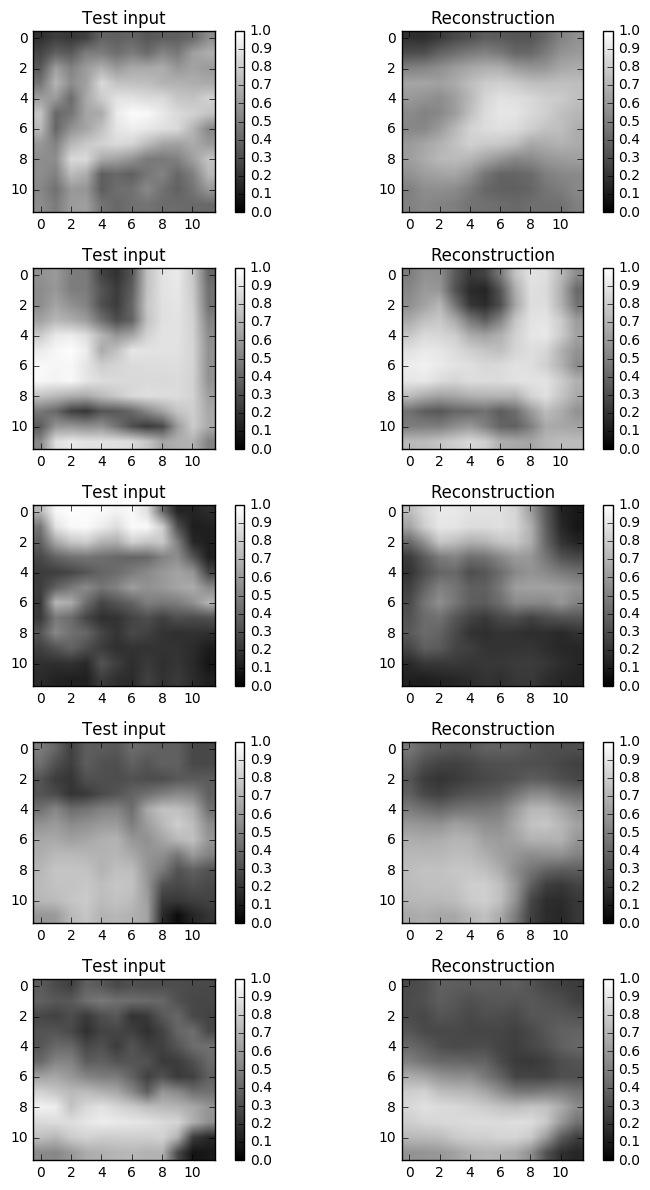

In [11]:
# MNIST
#x_sample = mnist.test.next_batch(100)[0]


# SYNTH
#x_sample = synxtest[:,0:100] # batch size
#x_sample = synxtrain[:,0:100]
#x_sample = np.transpose(x_sample)

# CIFAR
#x_sample = cifardat[0:100,:] # batch size
#x_sample = np.tranpose(x_sample)

# CIFARsm
x_sample = cifardatsm[0:100,:] # batch size
#x_sample = np.transpose(x_sample)

x_reconstruct = vae.reconstruct(x_sample)

canv = mask # 5 for synth, 28 for mnist 32 for cifar, mask for cifarsm
plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(canv, canv), vmin=0, vmax=1, cmap="gray")
    #plt.imshow(synxtest[:,i].reshape(canv, canv), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(canv, canv), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

(100, 144)


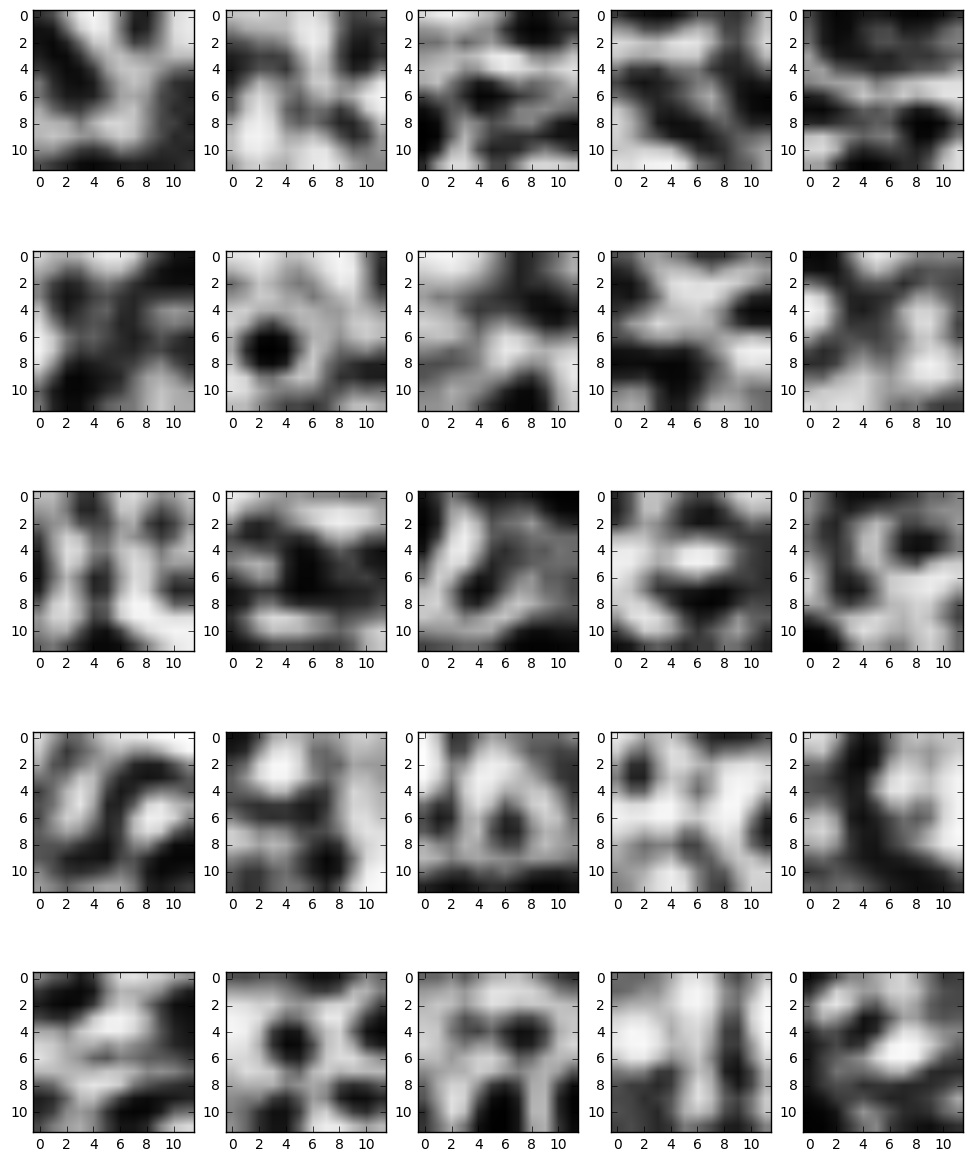

In [12]:
## Visualise Latent Vectors (from Synth Data / MNIST), compared to actual B
tester = np.eye(25)*10
tester = np.tile(tester,4)
tester = np.transpose(tester)
tester2 = np.random.rand(10,10)
tester2 = np.tile(tester2,10)
tester2 = np.transpose(tester2)
tester3 = np.eye(100)*25 # for 100 latent vars, using cifar
dat = vae.generate(tester)
canv =  mask# 5 for synth, 28 for mnist 32 for cifar mask for cifarsm
print(dat.shape)
plt.figure(figsize=(12, 15))
use = np.random.permutation(10)
use = np.arange(10)
#for i in range(10): # can be higher than 10 if using cifarsm
#    #plt.subplot(10, 2, 2*i + 1)
#    #plt.imshow(synB[:,i].reshape(canv, canv), vmin=0, vmax=1, cmap="gray")
#    #plt.title("B Vector")
#    #plt.colorbar()
#    plt.subplot(5, 2, 1*i+1)
#    plt.imshow(dat[use[i],:].reshape(canv, canv), vmin=0, vmax=1, cmap="gray")
#    plt.title("Latent Dimension")
#    plt.colorbar()
#plt.tight_layout()
#for i in range(5): # can be higher than 10 if using cifarsm
#    plt.subplot(5, 3, 3*i + 1)
#    plt.imshow(synB[:,i].reshape(canv, canv), vmin=0, vmax=1, cmap="gray")
#    plt.title("B Vector")
#    plt.colorbar()
#    plt.subplot(5, 3, 3*i + 2)
#    plt.imshow(dat[use[i],:].reshape(canv, canv), vmin=0, vmax=1, cmap="gray")
#    plt.title("Latent Dimension")
#    plt.colorbar()
#    plt.subplot(5, 3, 3*i + 3)
#    plt.imshow(dat[use[i+5],:].reshape(canv, canv), vmin=0, vmax=1, cmap="gray")
#    plt.title("Latent Dimension")
#    plt.colorbar()
#plt.tight_layout()
for i in range(25): # cifarsm
    plt.subplot(5, 5, i + 1)
    plt.imshow(dat[i,:].reshape(canv, canv), vmin=0, vmax=1, cmap="gray")

## Illustrating latent space

Next, we train a VAE with 2d latent space and illustrates how the encoder (the recognition network) encodes some of the labeled inputs (collapsing the Gaussian distribution in latent space to its mean). This gives us some insights into the structure of the learned manifold (latent space)

In [41]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         #n_input=25, #5x5 for synth
         #n_inputs=1024, #32 x 32 cifar
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=75)

Tensor("Placeholder_5:0", shape=(?, 784), dtype=float32)
Tensor("Sigmoid_5:0", shape=(100, 784), dtype=float32)
[array([[ 0.8569169 ,  0.68042785,  0.20321597, ...,  0.06468085,
         0.10373969,  0.18848471],
       [ 0.92069638,  0.34713826,  0.78005946, ...,  0.15288393,
         0.12151331,  0.76444221],
       [ 0.13021946,  0.17671849,  0.66283607, ...,  0.80449128,
         0.02300969,  0.34128958],
       ..., 
       [ 0.19357654,  0.28182524,  0.33810392, ...,  0.97462279,
         0.07044405,  0.00820567],
       [ 0.52291453,  0.8645283 ,  0.48254189, ...,  0.12875938,
         0.58067906,  0.75023144],
       [ 0.31483912,  0.96088809,  0.22009982, ...,  0.65071809,
         0.45405748,  0.1420538 ]], dtype=float32), array([[ 0.21039984,  0.64621449,  0.39690509, ...,  0.55352592,
         0.66461861,  0.45494536],
       [ 0.21644598,  0.66613936,  0.39169678, ...,  0.55319613,
         0.6680299 ,  0.44104645],
       [ 0.22445542,  0.6682778 ,  0.41456687, ...,  0.60

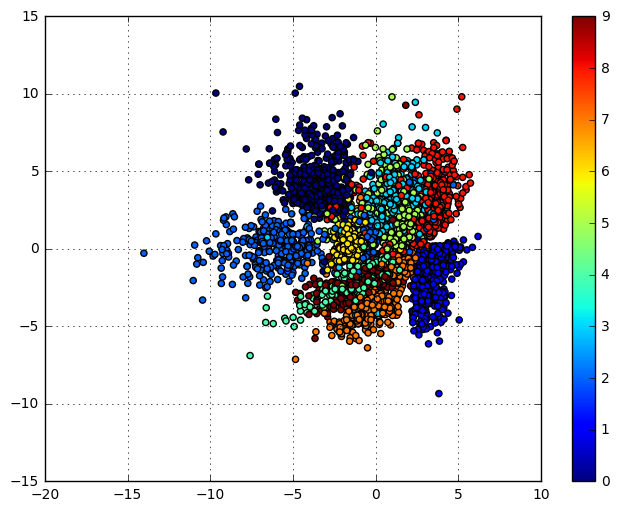

In [42]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

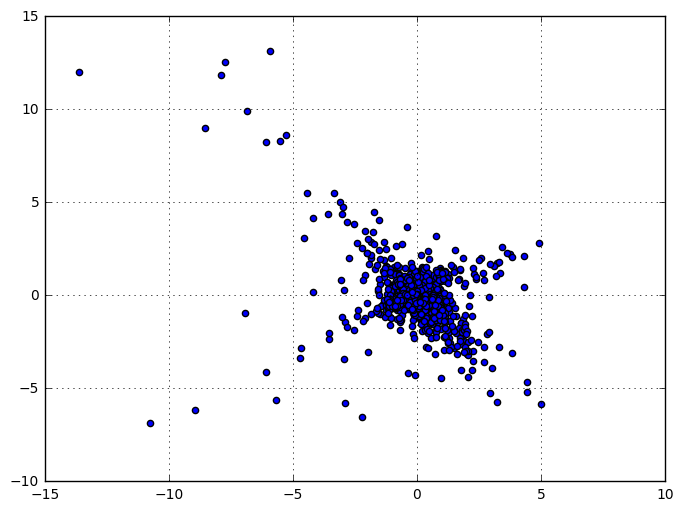

In [15]:
x_sample = synxtest[:,0:1000] # batch size
x_sample = np.transpose(x_sample)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1])
#plt.colorbar()
plt.grid()

An other way of getting insights into the latent space is to use the generator network to plot reconstrunctions at the positions in the latent space for which they have been generated:

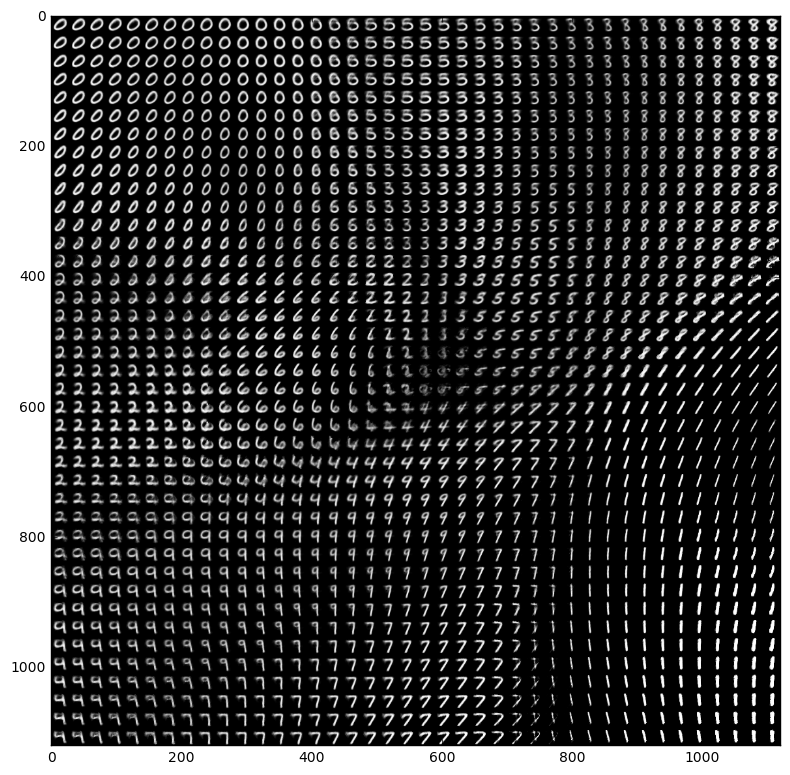

In [43]:
nx = ny = 40
x_values = np.linspace(-5, 5, nx)
y_values = np.linspace(-5, 5, ny)

canv = 28 # 28 for mnist, 5 for synth, 32 cifar
canvas = np.empty((canv*ny, canv*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*canv:(nx-i)*canv, j*canv:(j+1)*canv] = x_mean[0].reshape(canv, canv)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

## Summary
In summary, tensorflow is well suited to rapidly implement a prototype of machine learning models like VAE. The resulting code could be easily executed on GPUs as well (requiring just that tensorflow with GPU support was installed). VAE allows learning probabilistic encoders and decoders of data in an end-to-end fashion.

In [11]:
%load_ext watermark
%watermark -a "Jan Hendrik Metzen" -d -v -m -p numpy,scikit-learn,tensorflow

Jan Hendrik Metzen 2017-01-03 

CPython 3.5.1
IPython 5.1.0

numpy 1.11.2
scikit-learn 0.18.1
tensorflow 0.12.0-rc0

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 3.16.0-77-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 28
interpreter: 64bit


/miniconda/lib/python3.5/site-packages/watermark/watermark.py:143: DeprecationWarning: Importing scikit-learn as `scikit-learn` has been depracated and will not be supported anymore in v1.7.0. Please use the package name `sklearn` instead.
  DeprecationWarning)
